# Модель ТВП участков ГТС

### Импорт библиотек

In [1]:
import numpy as np
import pandas as pd
import datetime

from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

# Разделение датасета
from sklearn.model_selection import train_test_split, KFold, GridSearchCV

# Модели
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
# from lightgbm import LGBMRegressor

from statsmodels.tsa.seasonal import seasonal_decompose

# Модели временных рядов
from sktime.datasets import load_airline
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.utils.plotting import plot_series
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.theta import ThetaForecaster
from sktime.forecasting.ets import AutoETS
from sktime.forecasting.arima import AutoARIMA

from sktime.forecasting.model_evaluation import evaluate
from sktime.forecasting.model_selection import ExpandingWindowSplitter

from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError

# Метрики
from sklearn.metrics import mean_squared_error as mse, r2_score as r2

# Отключение предупреждений
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

# plt.style.use('ggplot')
%config IPCompleter.greedy=True # ускоряет автокомплит
plt.rcParams['figure.figsize'] = [10, 5] # задает размер графиков
plt.rcParams['figure.dpi'] = 200 # устанавливает разрешение (при экспорте можно увеличить)

 ## поля датасета

- 'sheet_name' - имя листа откуда производилось чтение информации, 
- 'line_id' - id участка, 
- 'line_name' - имя участка, 
- 'fact_month' - фактический поток в определенный месяц,
- 'tvps_with_rr' - ТВПС с учетом ремонтных работ, 
- 'tvps_without_rr' - ТВПС без учета ремонтных работ, 
- 'tvp_with_rr'- ТВП с учетом ремонтных работ, 
- 'tvp_without_rr' - ТВП без учета ремонтных работ,
- 'datetime - метка времени (год, месяц)'

Загрузка данных паспортов

In [2]:
df = pd.read_csv('./Passports_data.csv', sep='\t', encoding='utf-8',index_col='Unnamed: 0')
df['date_time'] = pd.to_datetime(df['time'])

df = df.drop(['time'], axis=1)
df = df.sort_values(by=['date_time'])

Пример данных - загружены значения ТВП по месяцам

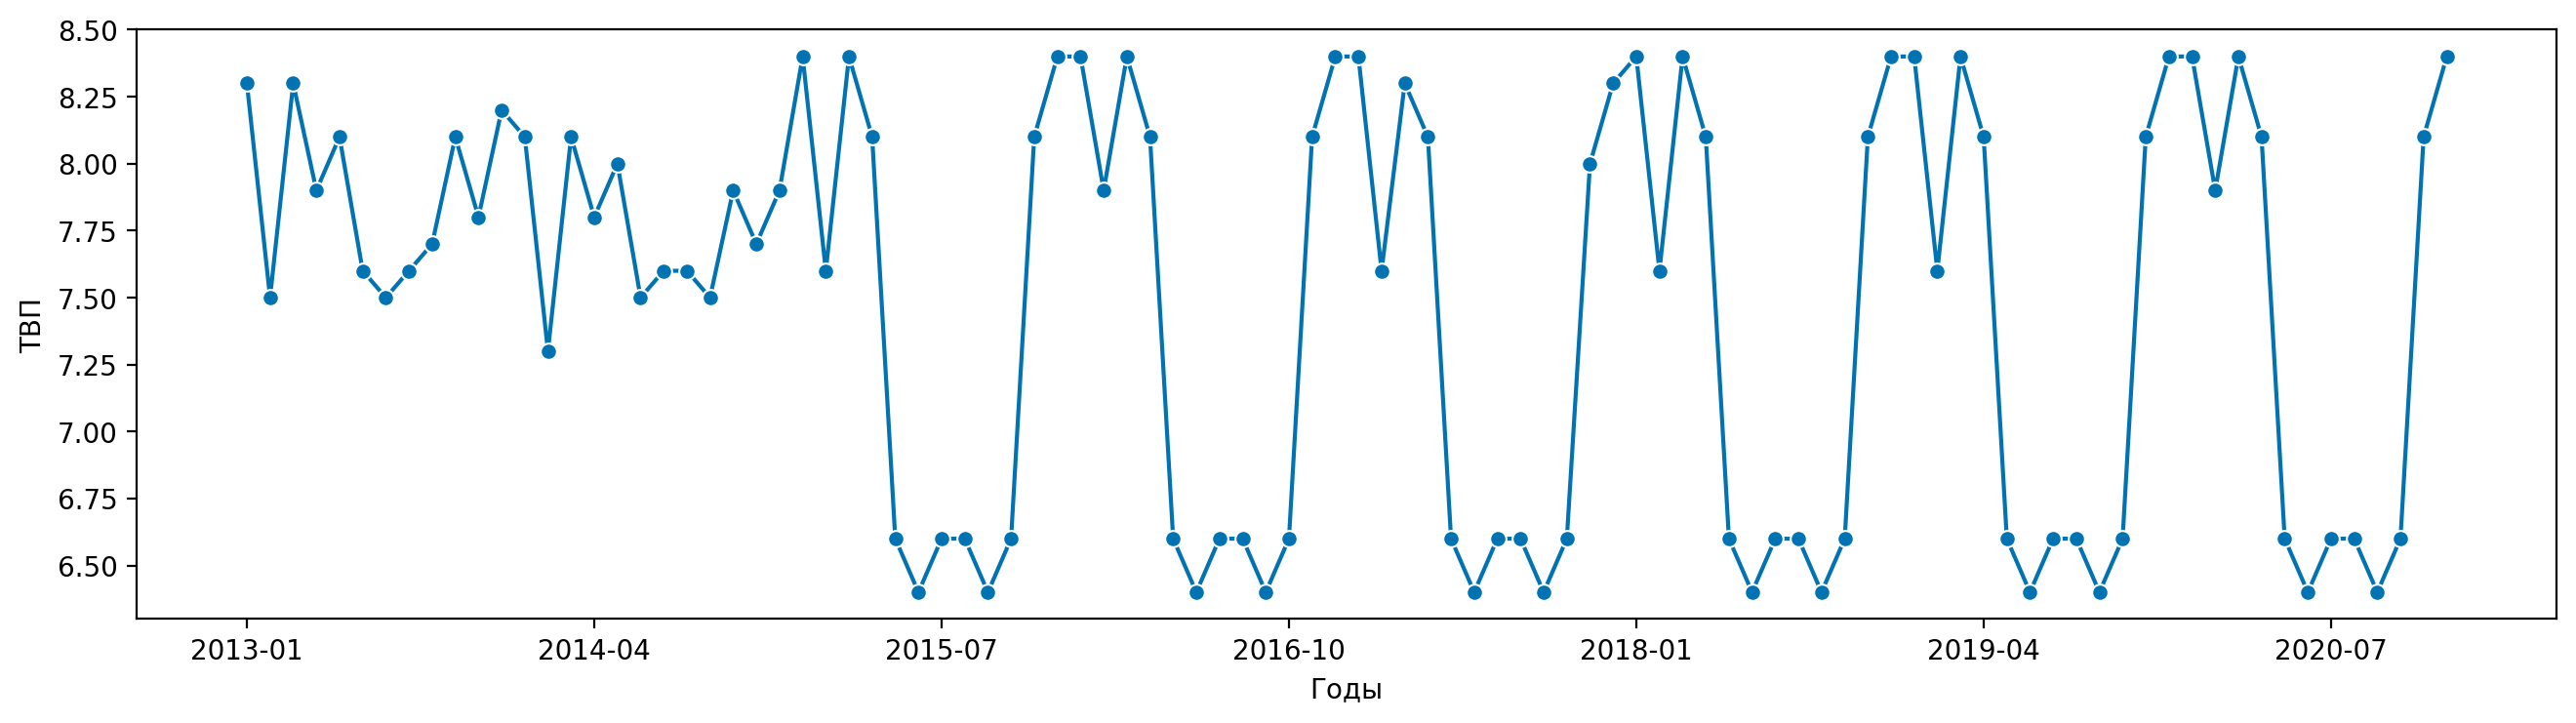

In [3]:
y = df.loc[((df['line_name']==df['line_name'][1]) &
             (df.date_time.dt.year > 2012))]\
        [['tvp_without_rr', 'date_time']].fillna(0)
y = y.set_index('date_time')
y = pd.Series(y['tvp_without_rr'].values, index=y.index.to_period())

# #plotting for visualization
plot_series(y, y_label='ТВП', x_label='Годы');

## Прогноз AutoARIMA

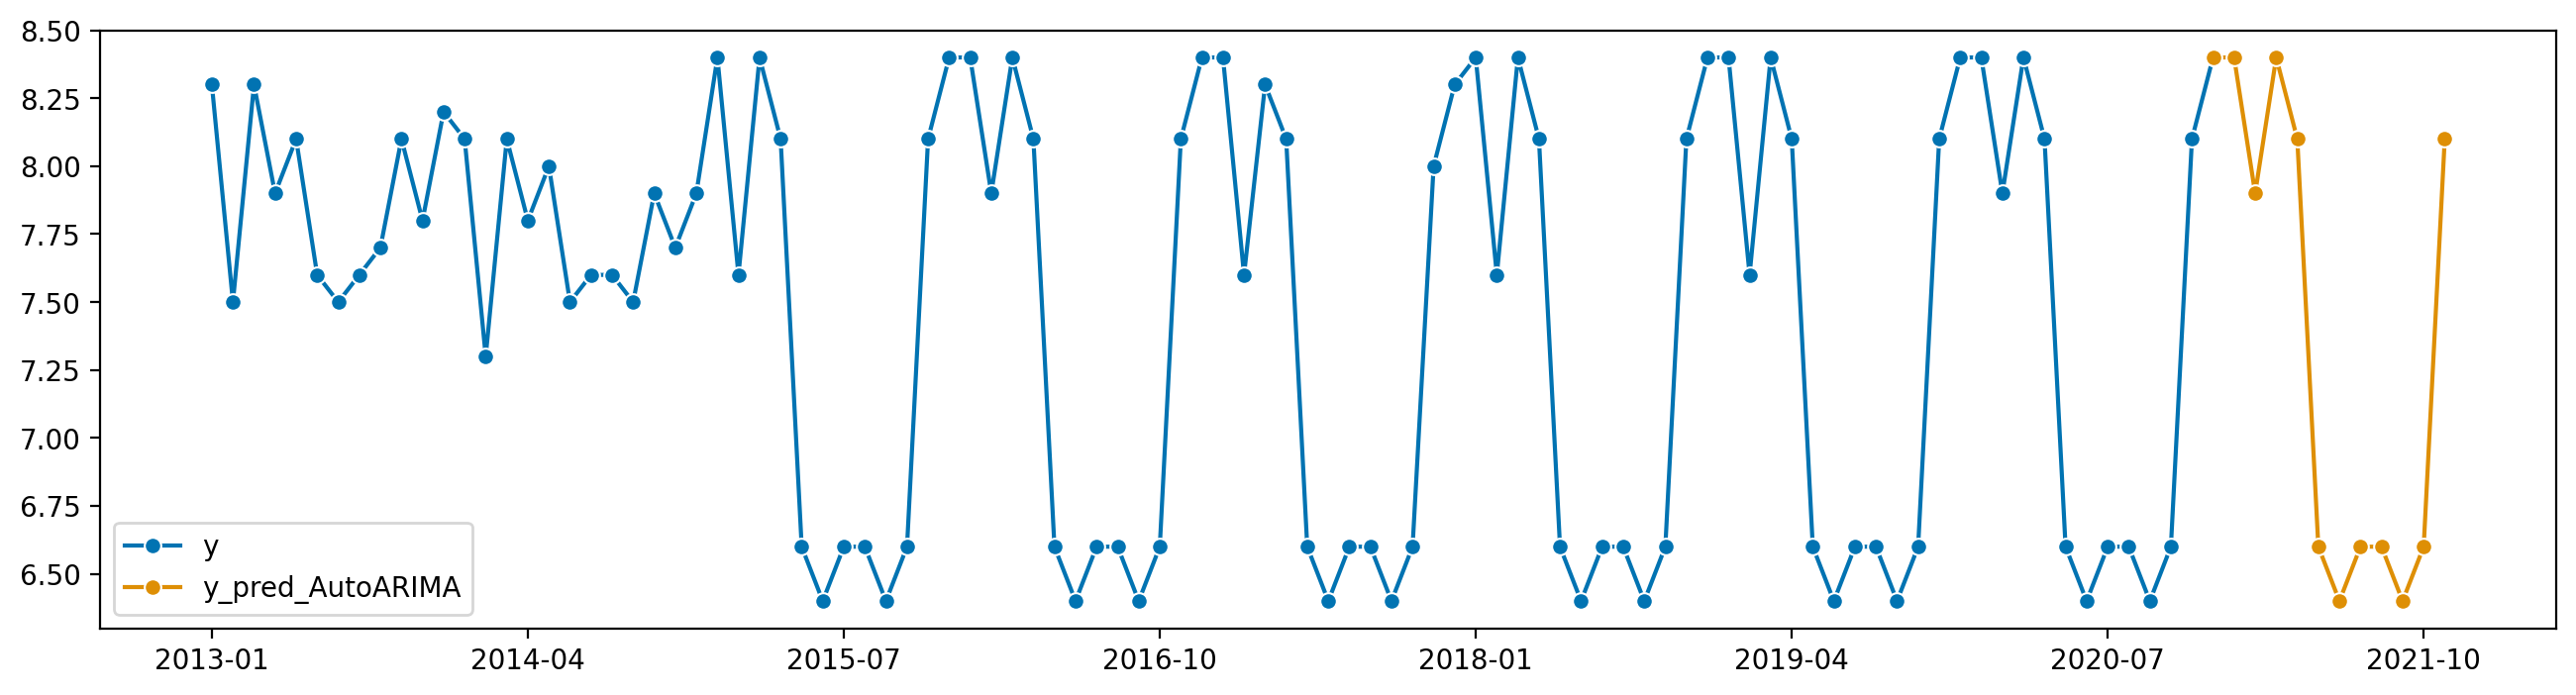

In [4]:
#Forecasting

forecast_period = 12

# y_train, y_test = temporal_train_test_split(y, test_size=forecast_period)

# fh = ForecastingHorizon(y_test.index, is_relative=False)

fh = ForecastingHorizon(
    pd.PeriodIndex(pd.date_range(str(y.index[-1].year) + '-' + str(y.index[-1].month),
                                 periods=forecast_period, freq="M")), 
    is_relative=False)

# Forecasters

forecaster_AutoARIMA = AutoARIMA(sp=forecast_period, suppress_warnings=True)

# forecaster_AutoETS = AutoETS(auto=True, sp=forecast_period, n_jobs=-1)

# forecaster_NaiveForecaster = NaiveForecaster(strategy="last", sp=forecast_period)

forecaster_AutoARIMA.fit(y)
y_pred_AutoARIMA = forecaster_AutoARIMA.predict(fh)

# forecaster_AutoETS.fit(y_train)
# y_pred_AutoETS = forecaster_AutoETS.predict(fh)

# forecaster_NaiveForecaster.fit(y_train)
# y_pred_NaiveForecaster = forecaster_NaiveForecaster.predict(fh)

plot_series(y, y_pred_AutoARIMA,
            labels=["y", "y_pred_AutoARIMA"]);


## Прогноз AutoARIMA на длинный период

In [5]:
y = df.loc[((df['line_name']==df['line_name'][1]) &
             (df.date_time.dt.year > 2014))]\
        [['tvp_without_rr', 'date_time']].fillna(0)
y = y.set_index('date_time')
y = pd.Series(y['tvp_without_rr'].values, index=y.index.to_period())
y_source = y.copy(deep=True)
y_pred = pd.Series()

for i in range(6):
    #Forecasting

    forecast_period = 12

    fh = ForecastingHorizon(
        pd.PeriodIndex(pd.date_range(str(y.index[-1].year) + '-' + str(y.index[-1].month),
                                     periods=forecast_period, freq="M")), 
        is_relative=False)

    # Forecasters

    forecaster_AutoARIMA = AutoARIMA(sp=forecast_period, suppress_warnings=True)

    forecaster_AutoARIMA.fit(y)
    y_pred_AutoARIMA = forecaster_AutoARIMA.predict(fh)

    y = pd.concat([y, y_pred_AutoARIMA])
    y_pred = pd.concat([y_pred, y_pred_AutoARIMA])
    
    if i < 1:
        print(f'Выполнен прогноз на {i+1} год')
    elif i < 4:
        print(f'Выполнен прогноз на {i+1} года')
    else:
        print(f'Выполнен прогноз на {i+1} лет')
# plot_series(y_source, y_pred);


Выполнен прогноз на 1 год
Выполнен прогноз на 2 года
Выполнен прогноз на 3 года
Выполнен прогноз на 4 года
Выполнен прогноз на 5 лет
Выполнен прогноз на 6 лет


(<Figure size 3200x800 with 1 Axes>, <AxesSubplot:>)

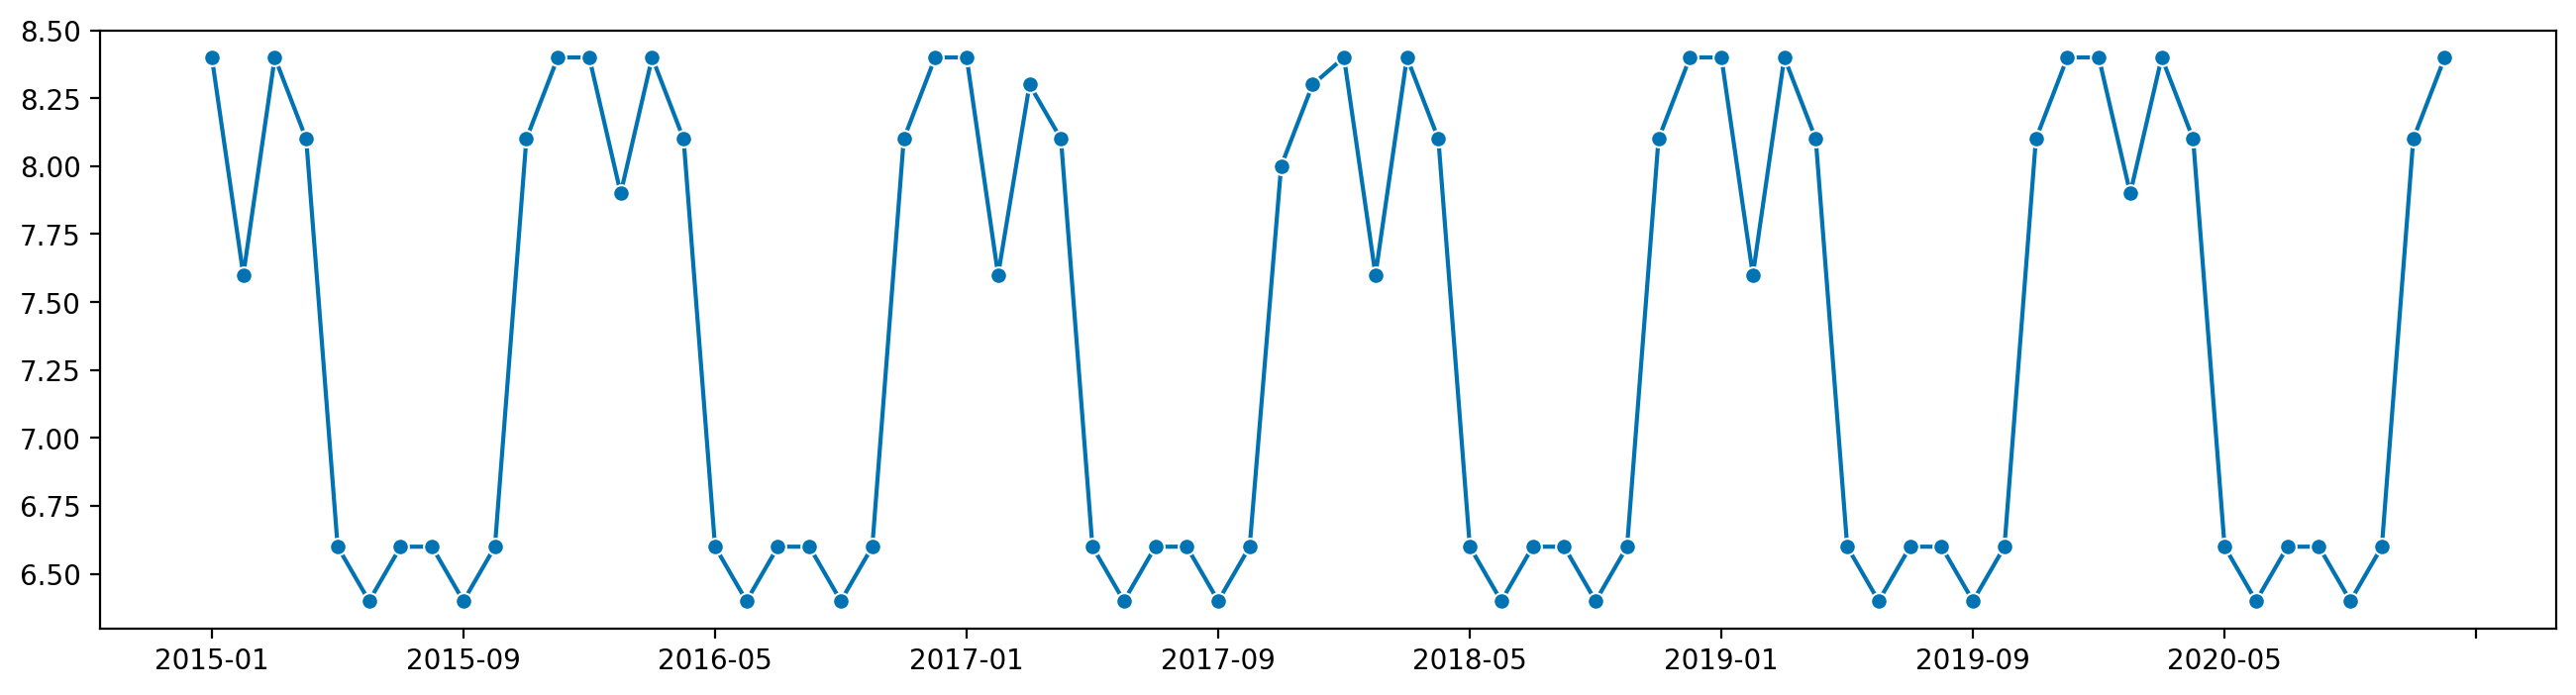

In [6]:
plot_series(y_source)

<AxesSubplot:>

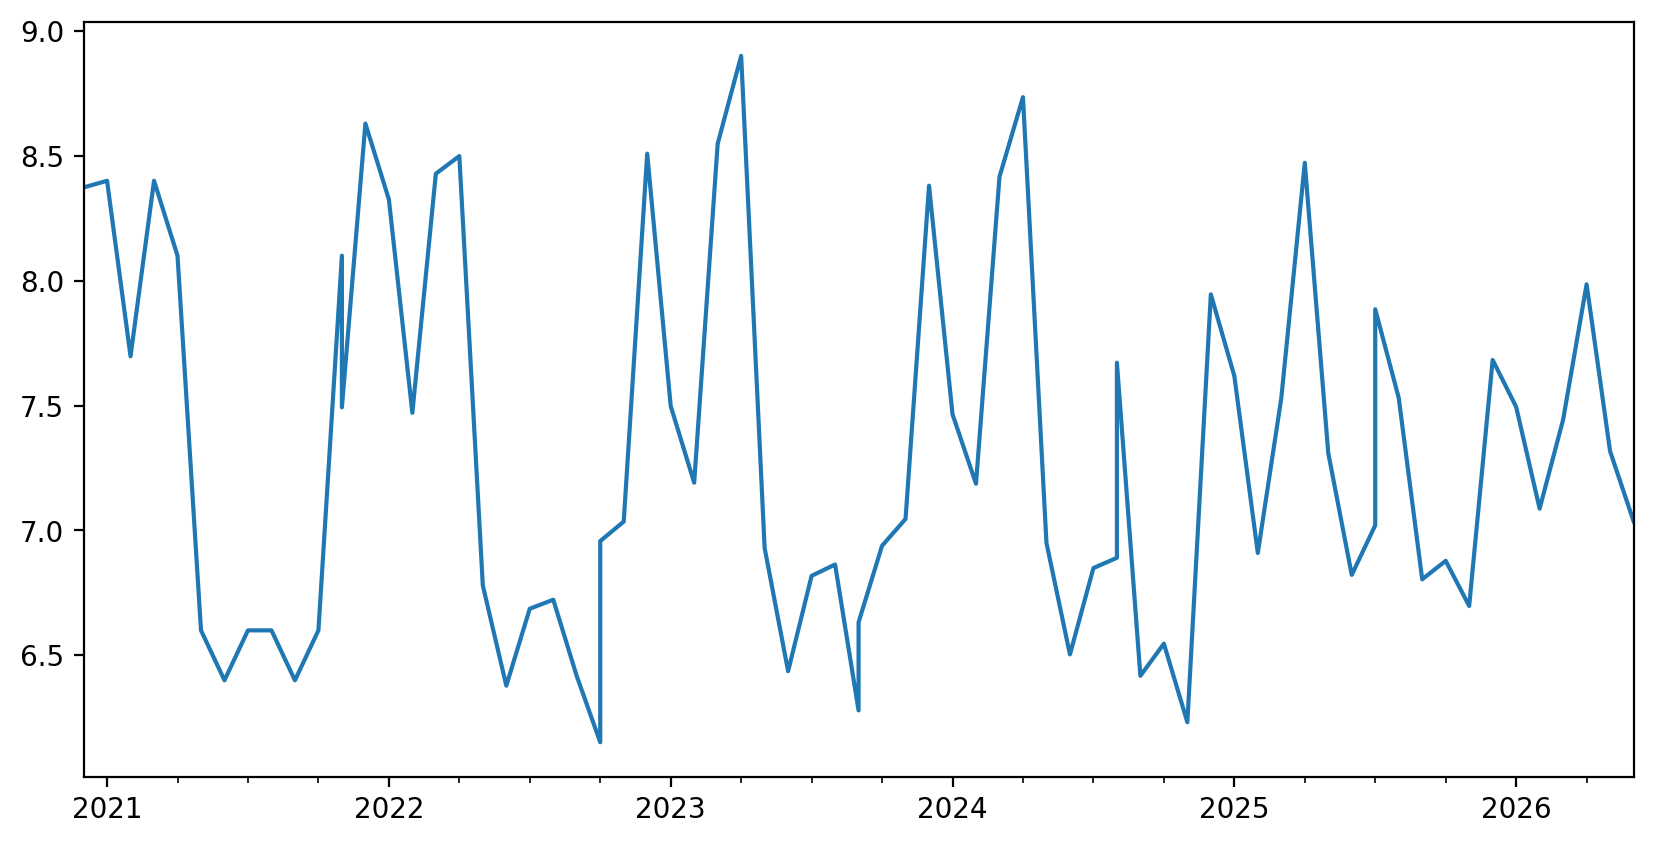

In [7]:
y_pred.plot()

### Получилось плохо :(
Автоматом прогноз начинает врать на длительном периоде.

# Разложение на компоненты
Разложим исходный временной ряд для выделения тренда, гармонической составляющей и шума

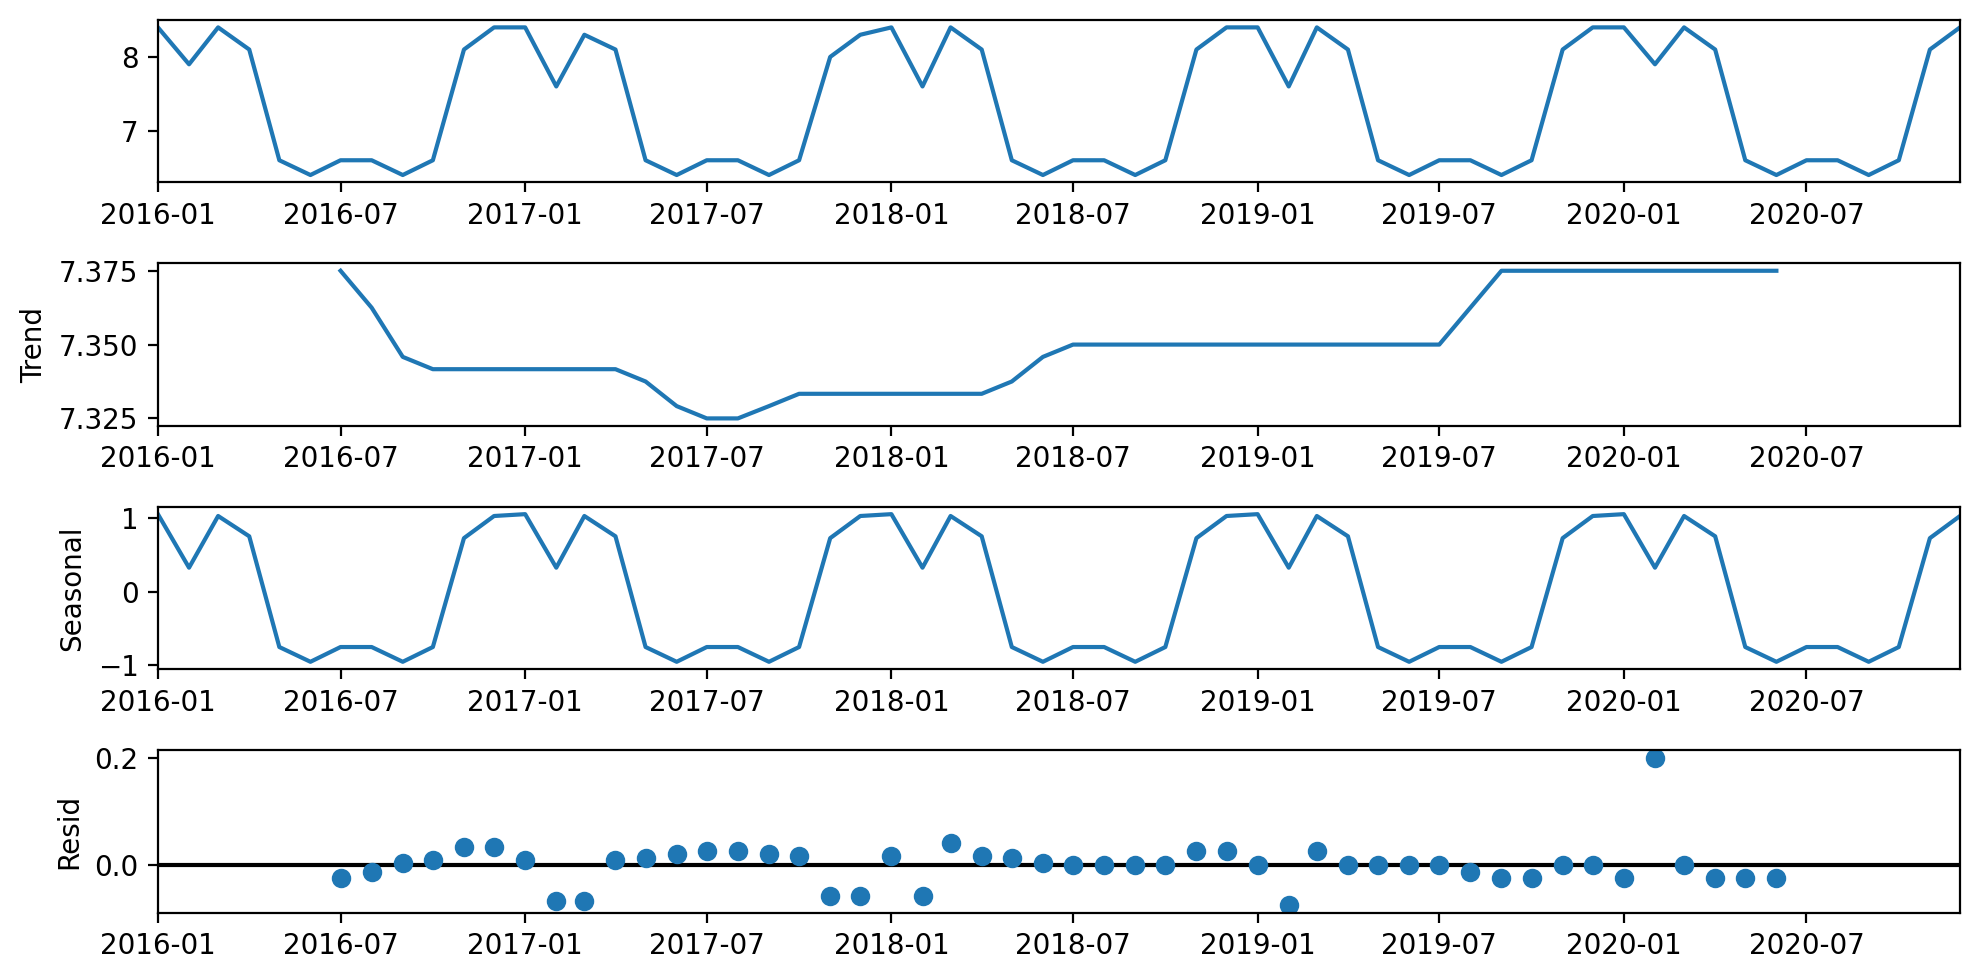

In [8]:
y = df.loc[((df['line_name']==df['line_name'][1]) &
             (df.date_time.dt.year > 2015))]\
        [['tvp_without_rr', 'date_time']].fillna(0)
y = y.set_index('date_time')
y = pd.Series(y['tvp_without_rr'].values, index=y.index)

result = seasonal_decompose(y, model='additive')
result.plot();

Text(0.5, 1.0, 'Сезонная составляющая')

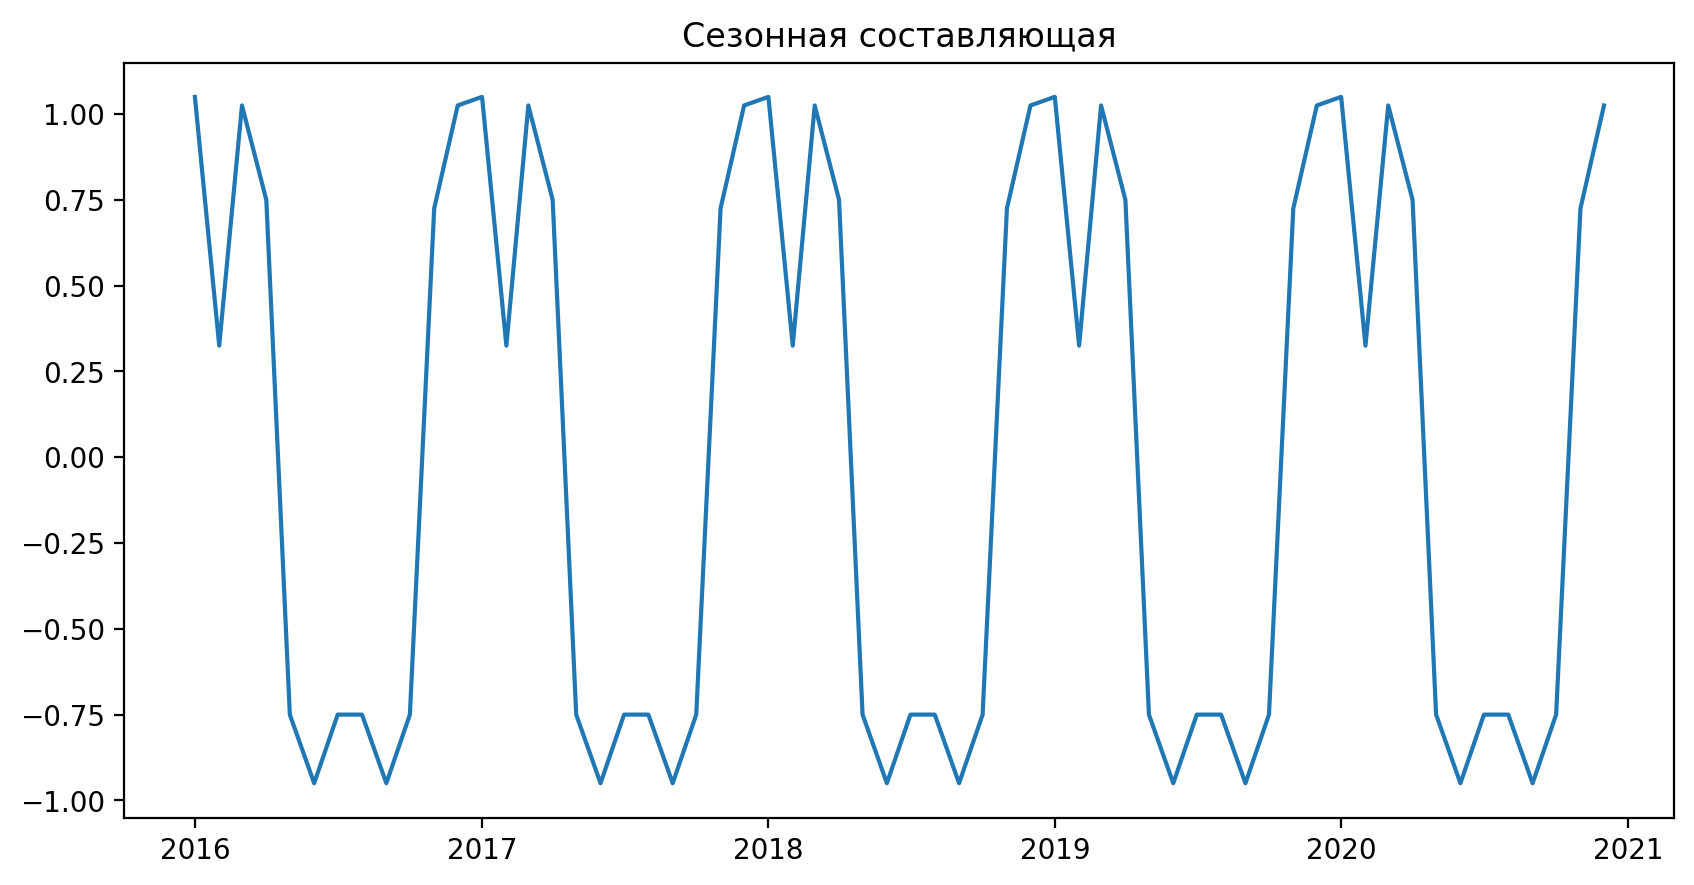

In [9]:
plt.plot(result.seasonal)
plt.title('Сезонная составляющая')

Text(0.5, 1.0, 'Тренд [млрд.м3 / год]')

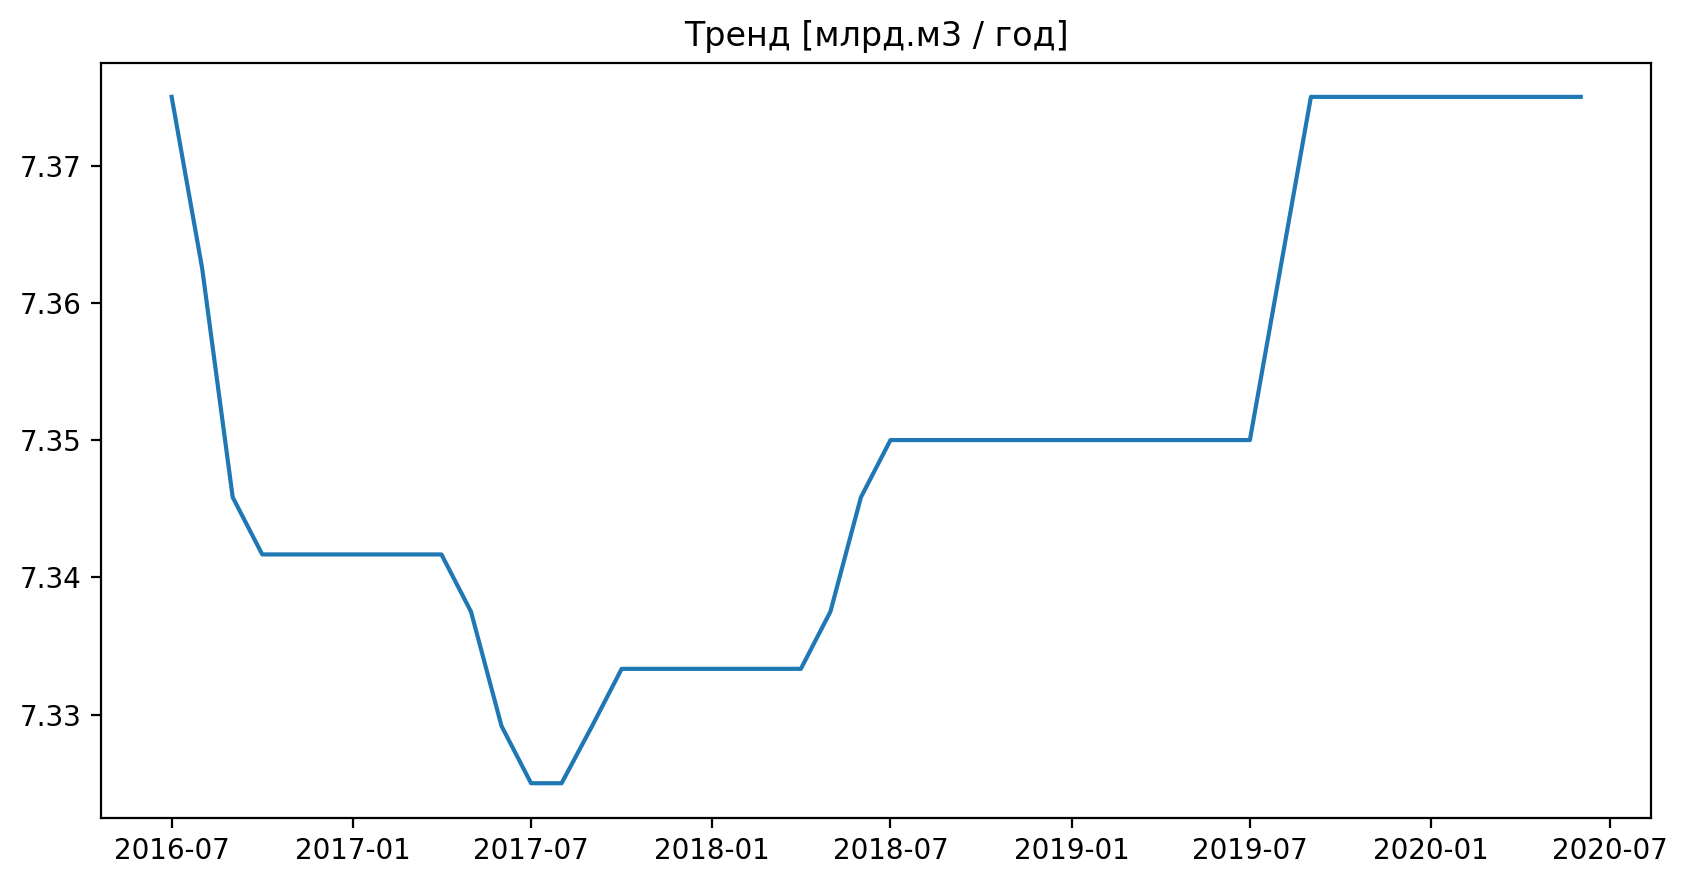

In [10]:
plt.plot(result.trend)
plt.title('Тренд [млрд.м3 / год]')

Text(0.5, 1.0, 'Тренд изменения ТВП по участку: КС Пуровская – КС Правохеттинская: Вход КС Пуровская')

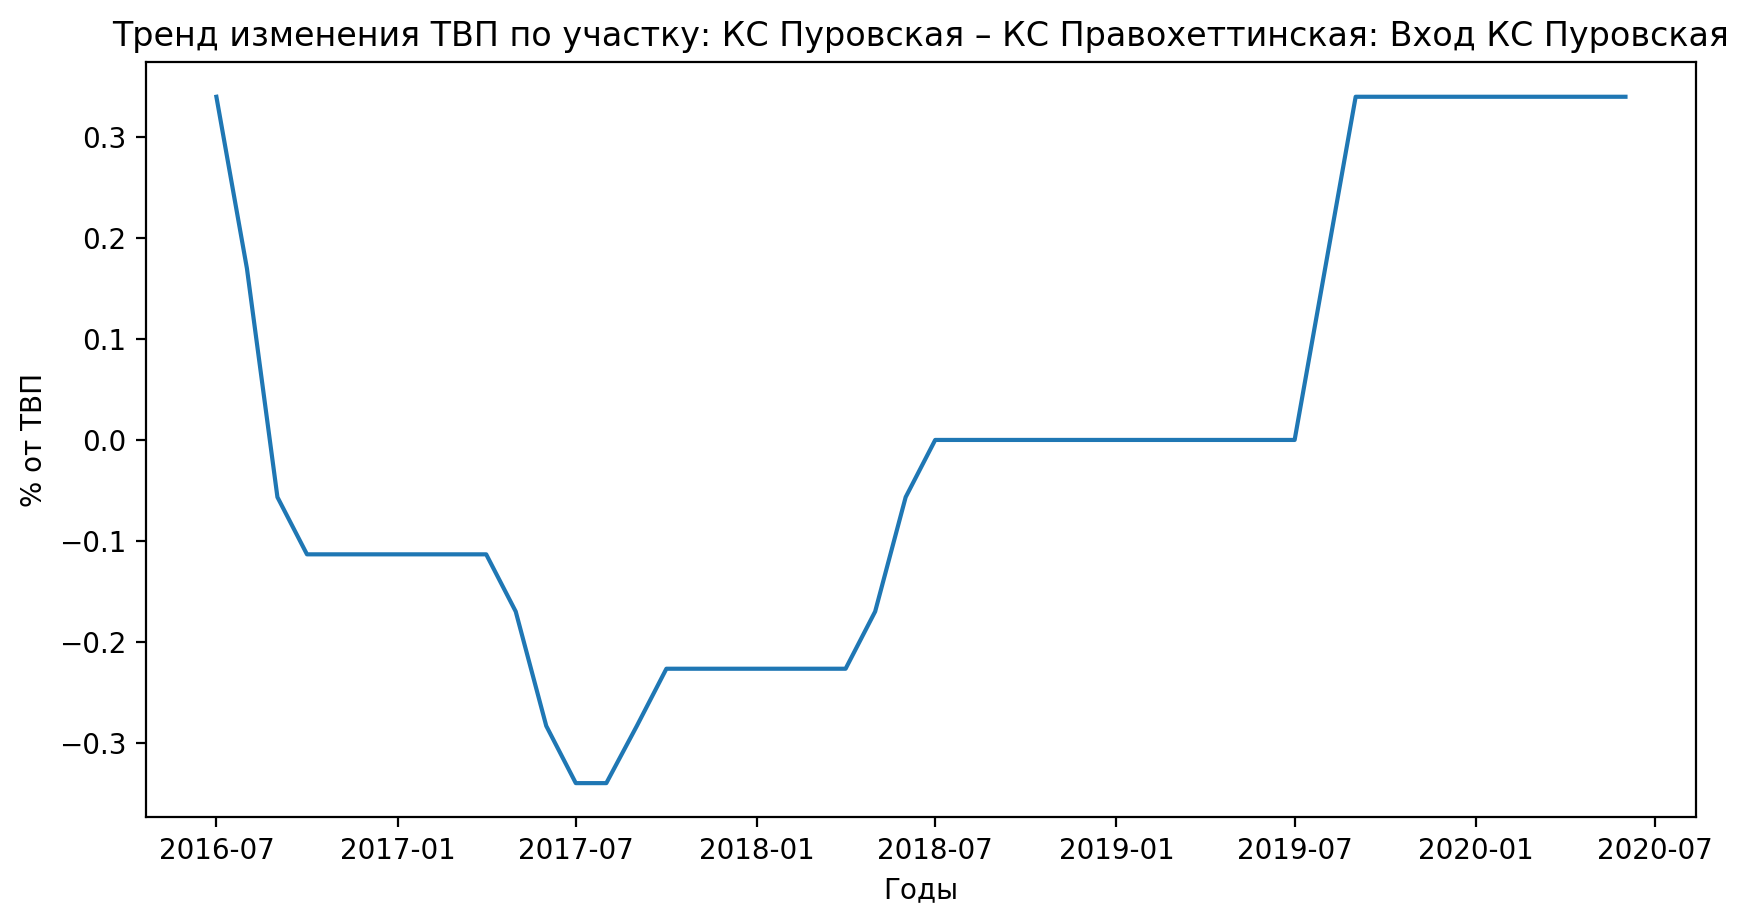

In [11]:
plt.plot((result.trend/result.trend.mean()-1)*100)
plt.xlabel('Годы')
plt.ylabel('% от ТВП')
plt.title(f'Тренд изменения ТВП по участку: {df["line_name"][1]}')

Разница между исходным рядом и сезонной компонентой

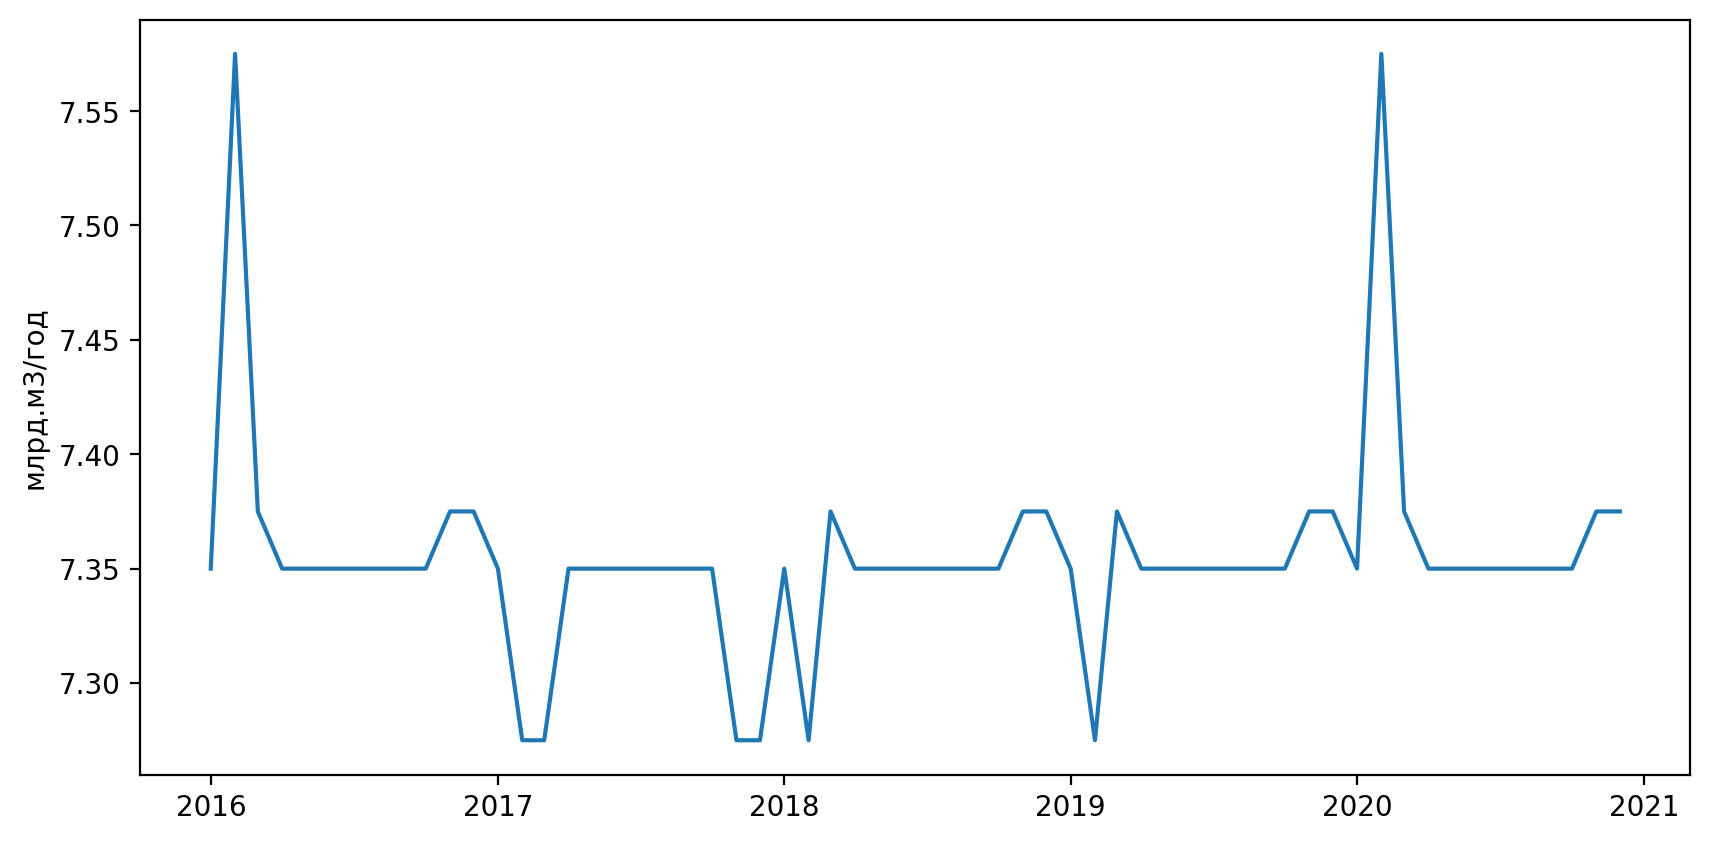

In [12]:
plt.plot(result.observed - result.seasonal)
plt.ylabel('млрд.м3/год')
plt.show()

Пройдем по участкам и соберем те, где падение ТВП за период наблюдений составило более 10%

In [13]:
# Отдельно соберем ошибки и итоговую таблицу
err_list = []
critical_lines = pd.DataFrame(columns=['Line', 'TVP_fall_%'])

In [14]:

for l_name in df['line_name'].unique():
    y = df.loc[((df['line_name']==l_name) &
             (df.date_time.dt.year > 2010))]\
        [['tvp_without_rr', 'date_time']].fillna(0)
    y = y.set_index('date_time')
    y = pd.Series(y['tvp_without_rr'].values, index=y.index)

    try:
        result = seasonal_decompose(y, model='additive')
    except:
        err_list.append(l_name)
    
    if result.trend.describe()['std'] > 0.1:
#         print(f'{l_name}: {result.trend.describe()["std"]}')
        critical_lines.loc[len(critical_lines)] = [l_name, result.trend.describe()["std"]*100]
print('\n')
print('* '*20)
print(err_list)



* * * * * * * * * * * * * * * * * * * * 
['Гос. граница РФ – Калининградское ПХГ: Гос. граница РФ', 'Гос. граница РФ – Калининградское ПХГ: Вход Калининградского ПХГ']


Соберем итоговую таблицу с участками, где падение ТВП за наблюдаемый период по выделенному тренду составило более 10:

In [15]:
critical_lines.sort_values(by=['TVP_fall_%'], ascending=False)

,Line,TVP_fall_%
302,КС Правохеттинская – КС Сосновская: Вход КС Пр...,558.058034
243,КС Правохеттинская – КС Сосновская: Вход КС Со...,550.101161
268,КС Сосновская – КС Таежная: Вход КС Сосновская,535.267694
272,КС Сосновская – КС Таежная: Выход КС Таежная,522.412661
285,КС Пангоды – КС Надым: Вход КС Пангоды,369.926778
...,...,...
121,КС Богандинская – КС Проскоково: 24 км МГ Ново...,12.750619
54,КС Кущевская-КС Майкопская: Справочно: вход в ...,12.675814
299,КС Валдай – КС Изборск: Выход КС Валдай,10.856529
300,Гос. граница (ГИС Смоленск) – ГИС Мозырь: ГИС ...,10.647331


Посмотрим на участок с самым большим падением и отрисуем результат

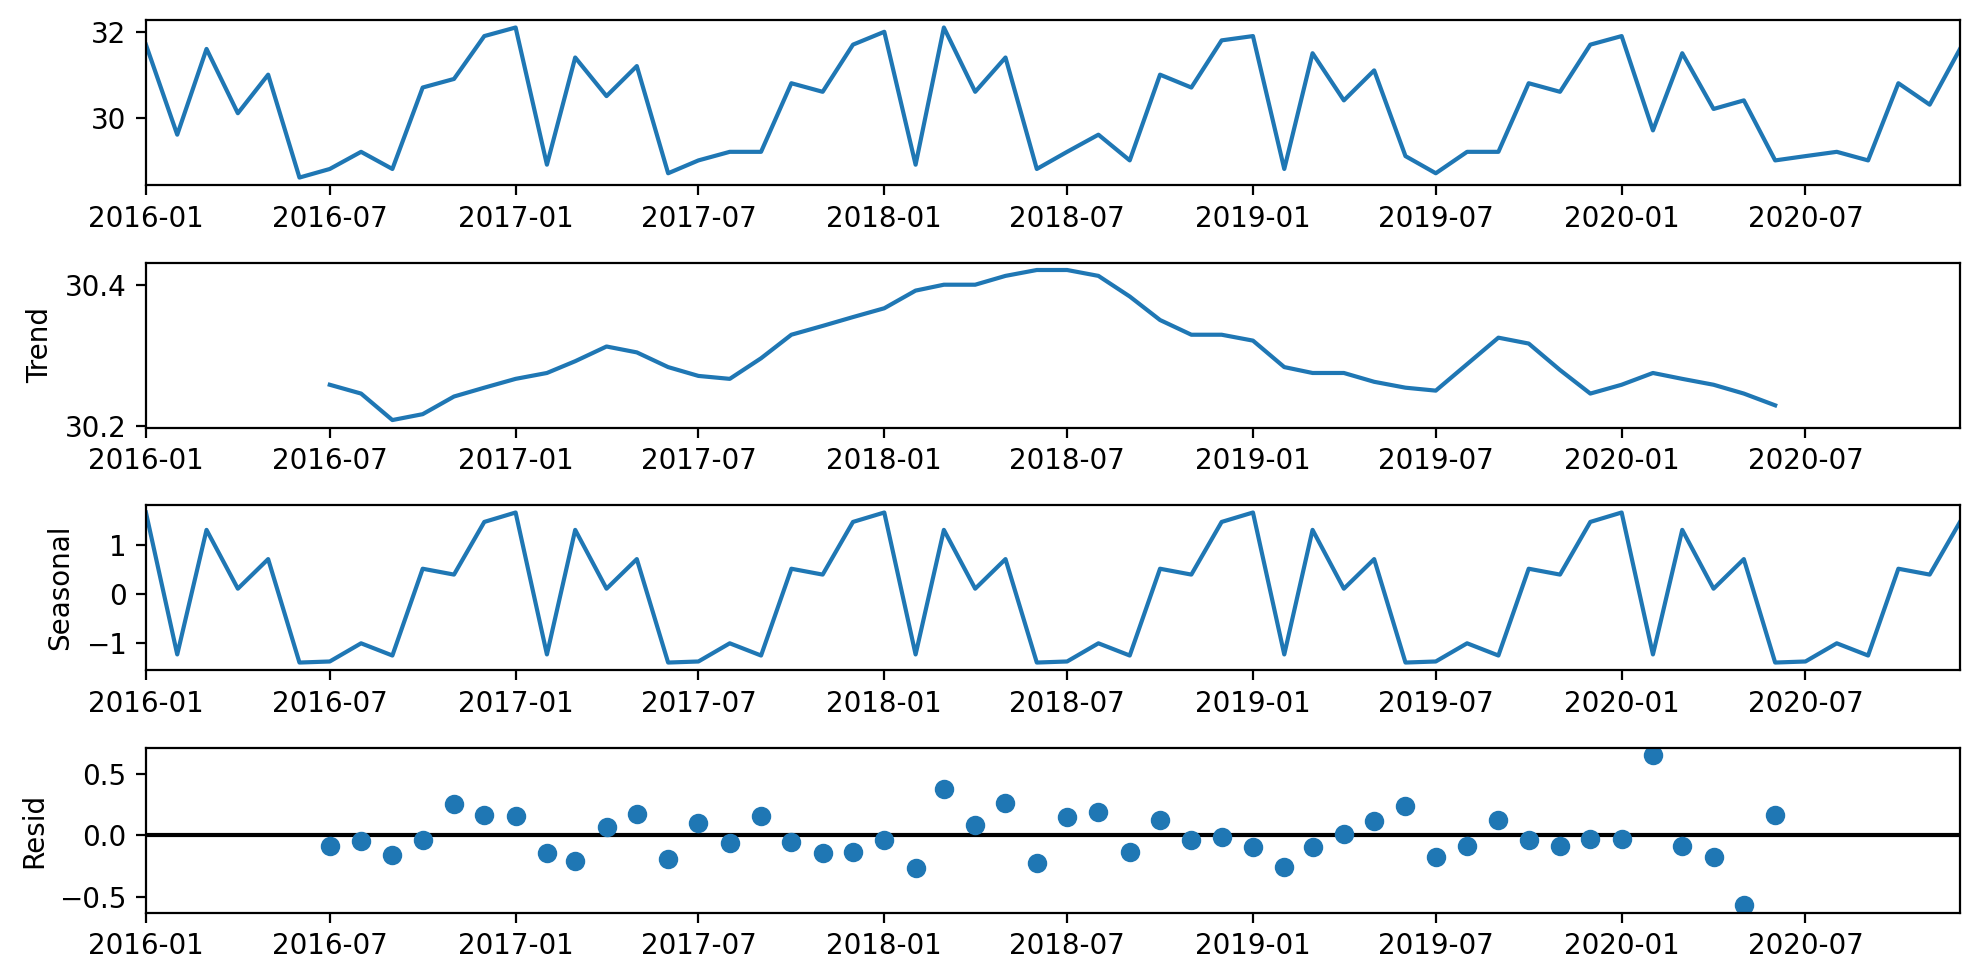

In [16]:
cr_line = critical_lines.sort_values(by=['TVP_fall_%'], ascending=False).loc[302, 'Line']

y = df.loc[((df['line_name']==cr_line) &
             (df.date_time.dt.year > 2015))]\
        [['tvp_without_rr', 'date_time']].fillna(0)
y = y.set_index('date_time')
y = pd.Series(y['tvp_without_rr'].values, index=y.index)

result = seasonal_decompose(y, model='additive')
result.plot();

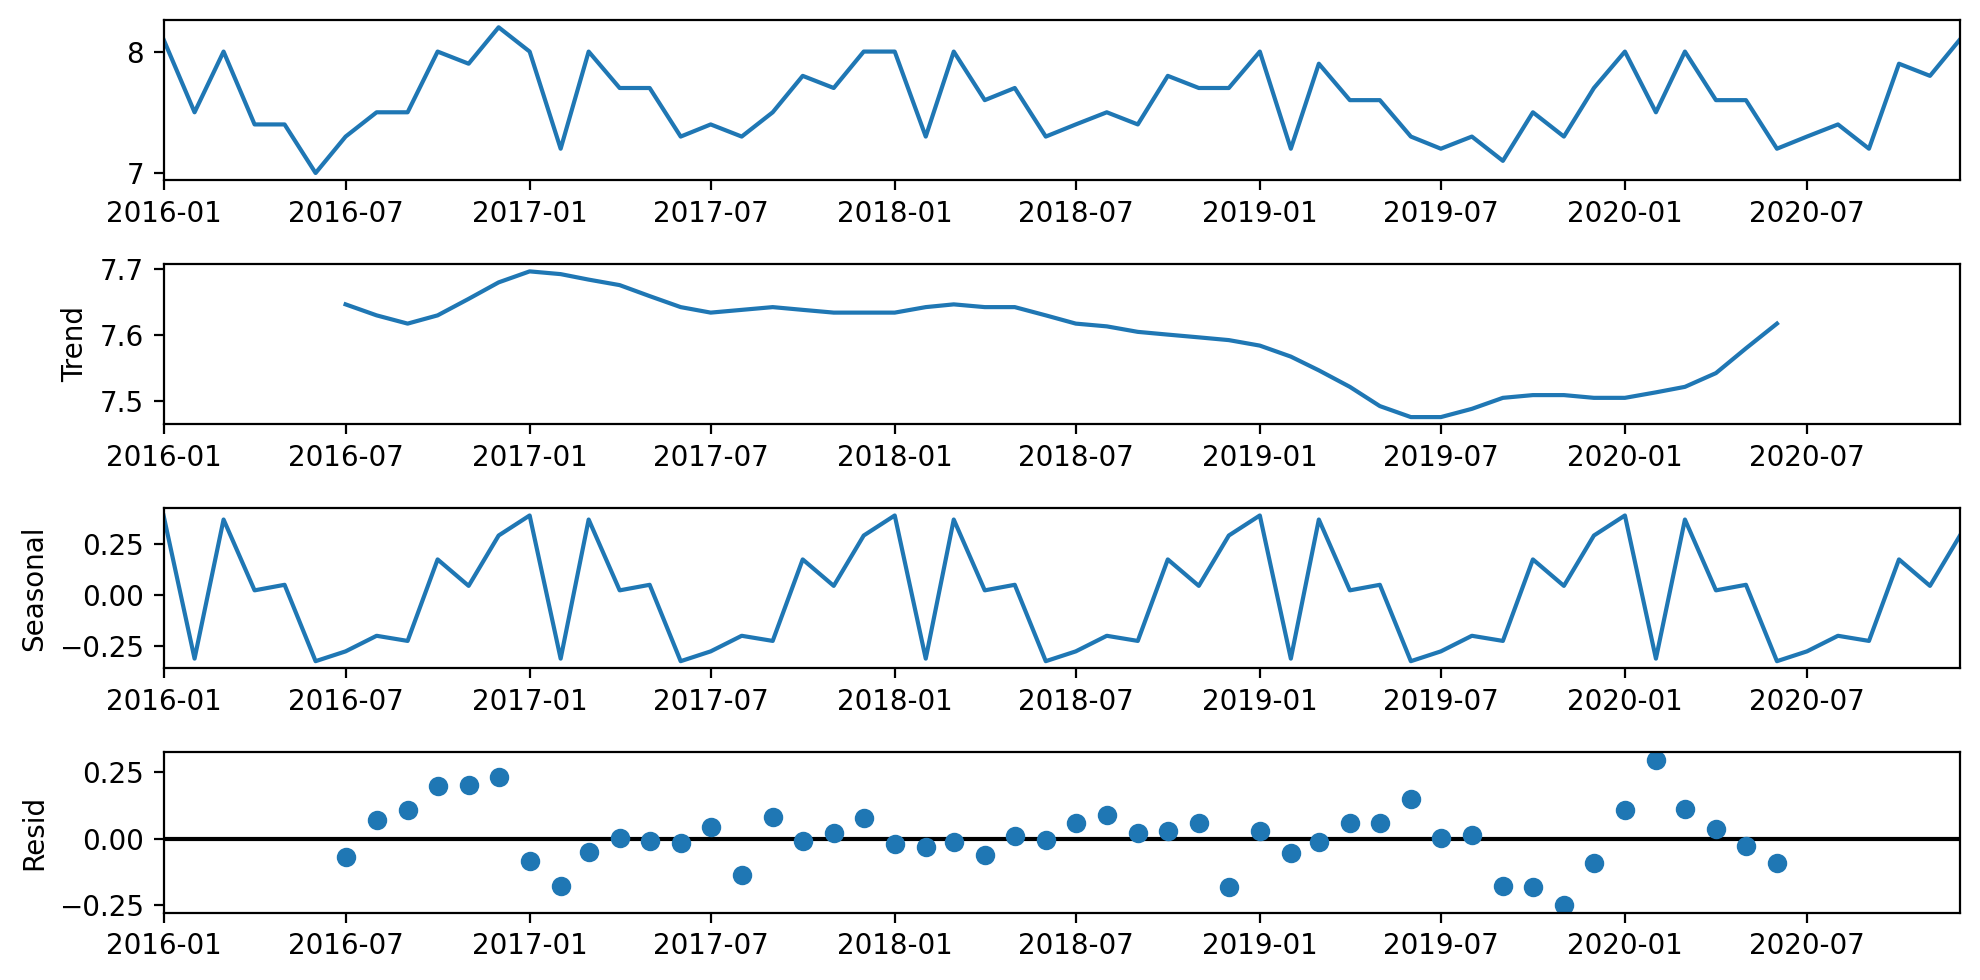

In [17]:
cr_line = critical_lines.sort_values(by=['TVP_fall_%'], ascending=False).loc[40, 'Line']

y = df.loc[((df['line_name']==cr_line) &
             (df.date_time.dt.year > 2015))]\
        [['tvp_without_rr', 'date_time']].fillna(0)
y = y.set_index('date_time')
y = pd.Series(y['tvp_without_rr'].values, index=y.index)

result = seasonal_decompose(y, model='additive')
result.plot();

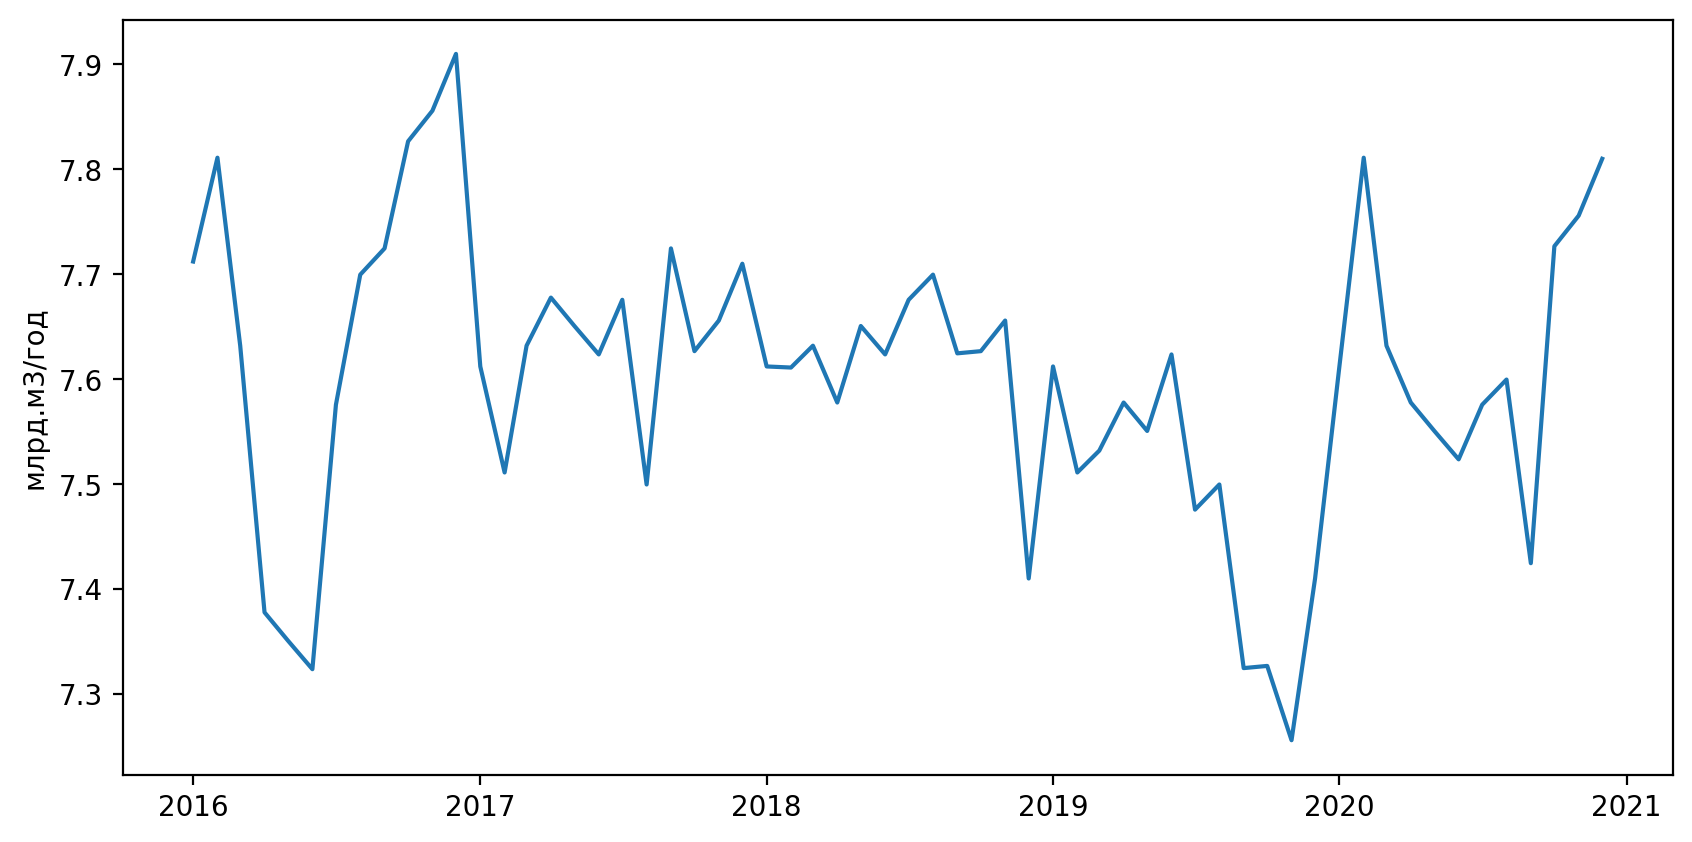

In [18]:
plt.plot(result.observed - result.seasonal)
plt.ylabel('млрд.м3/год')
plt.show()

Судя по всему проблема в недостатке данных. Нужно добавить дополнительную фильтрацию, что бы ситуация когда у нас нет данных не приводила к большим ошибкам.

**Работать только с временным интервалом, когда данные есть!!!**

## В явном виде построим прогноз разложив на сезонность и тренд

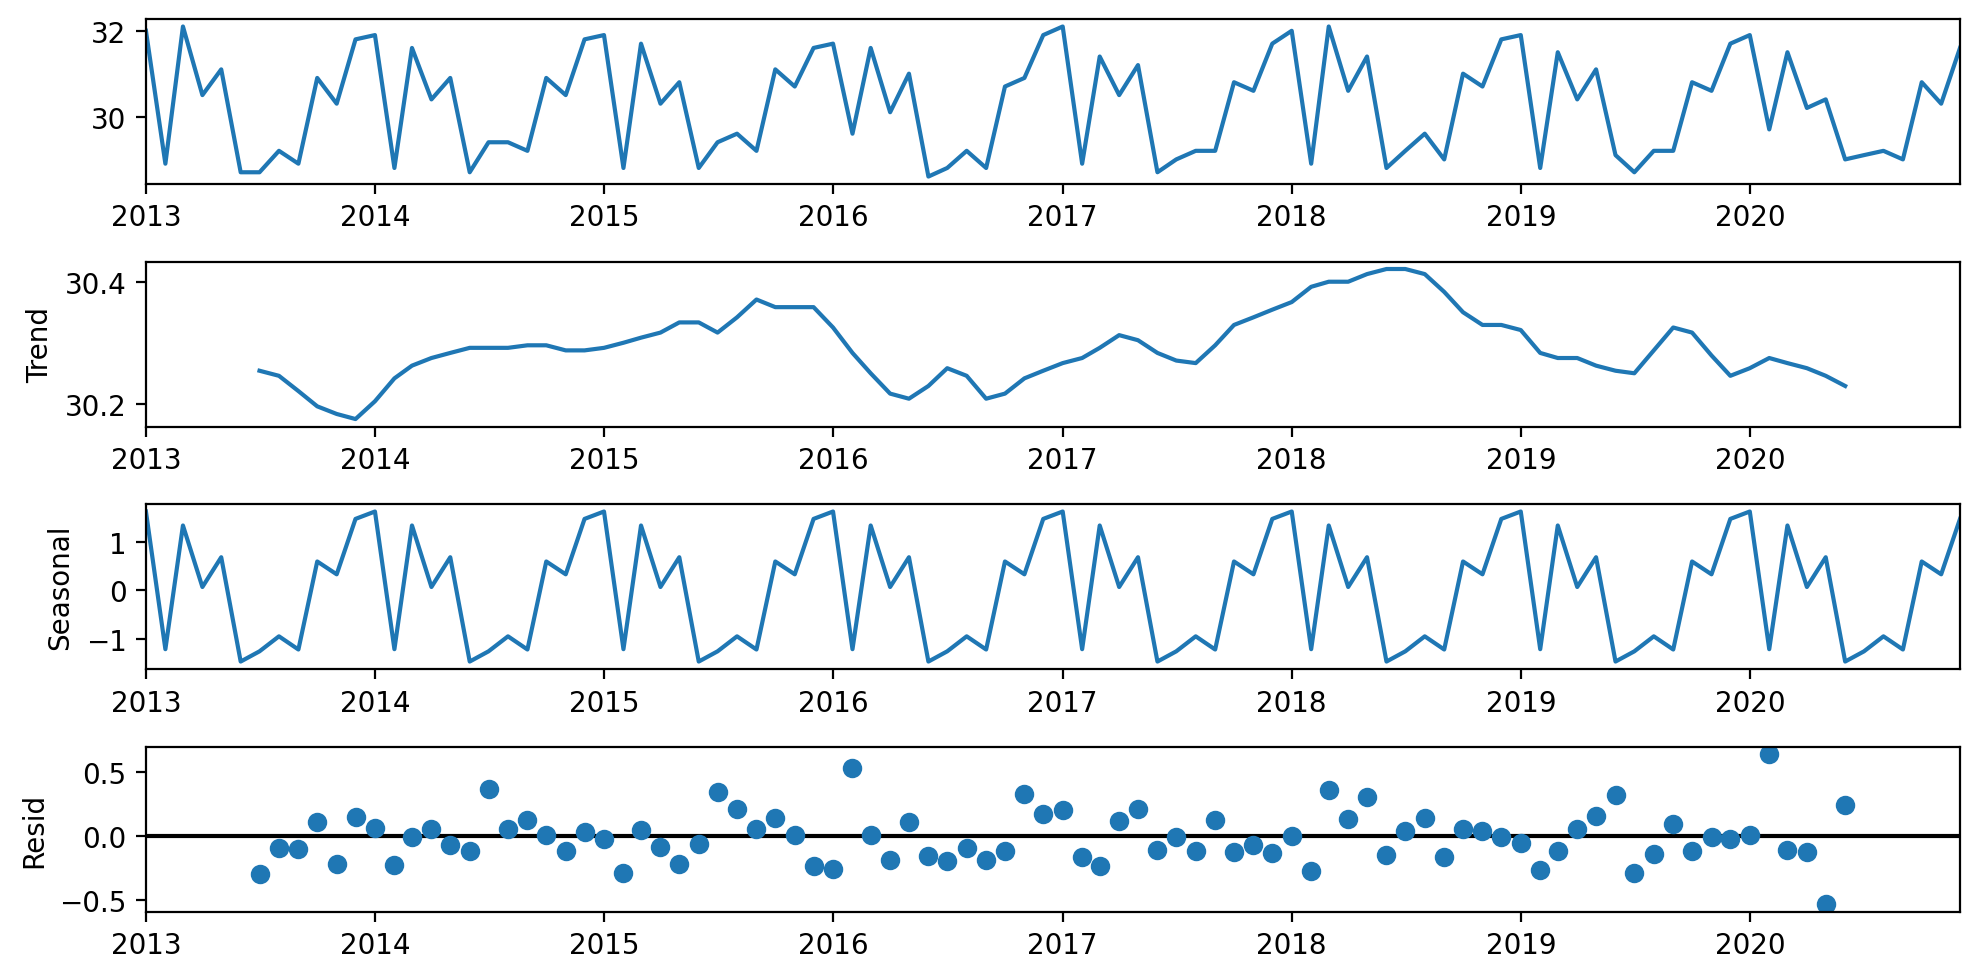

In [27]:
cr_line = critical_lines.sort_values(by=['TVP_fall_%'], ascending=False).loc[302, 'Line']

y = df.loc[((df['line_name']==cr_line) &
             (df.date_time.dt.year > 2012))]\
        [['tvp_without_rr', 'date_time']].fillna(0)
y = y.set_index('date_time')
y = pd.Series(y['tvp_without_rr'].values, index=y.index)

result = seasonal_decompose(y, model='additive')
result.plot();


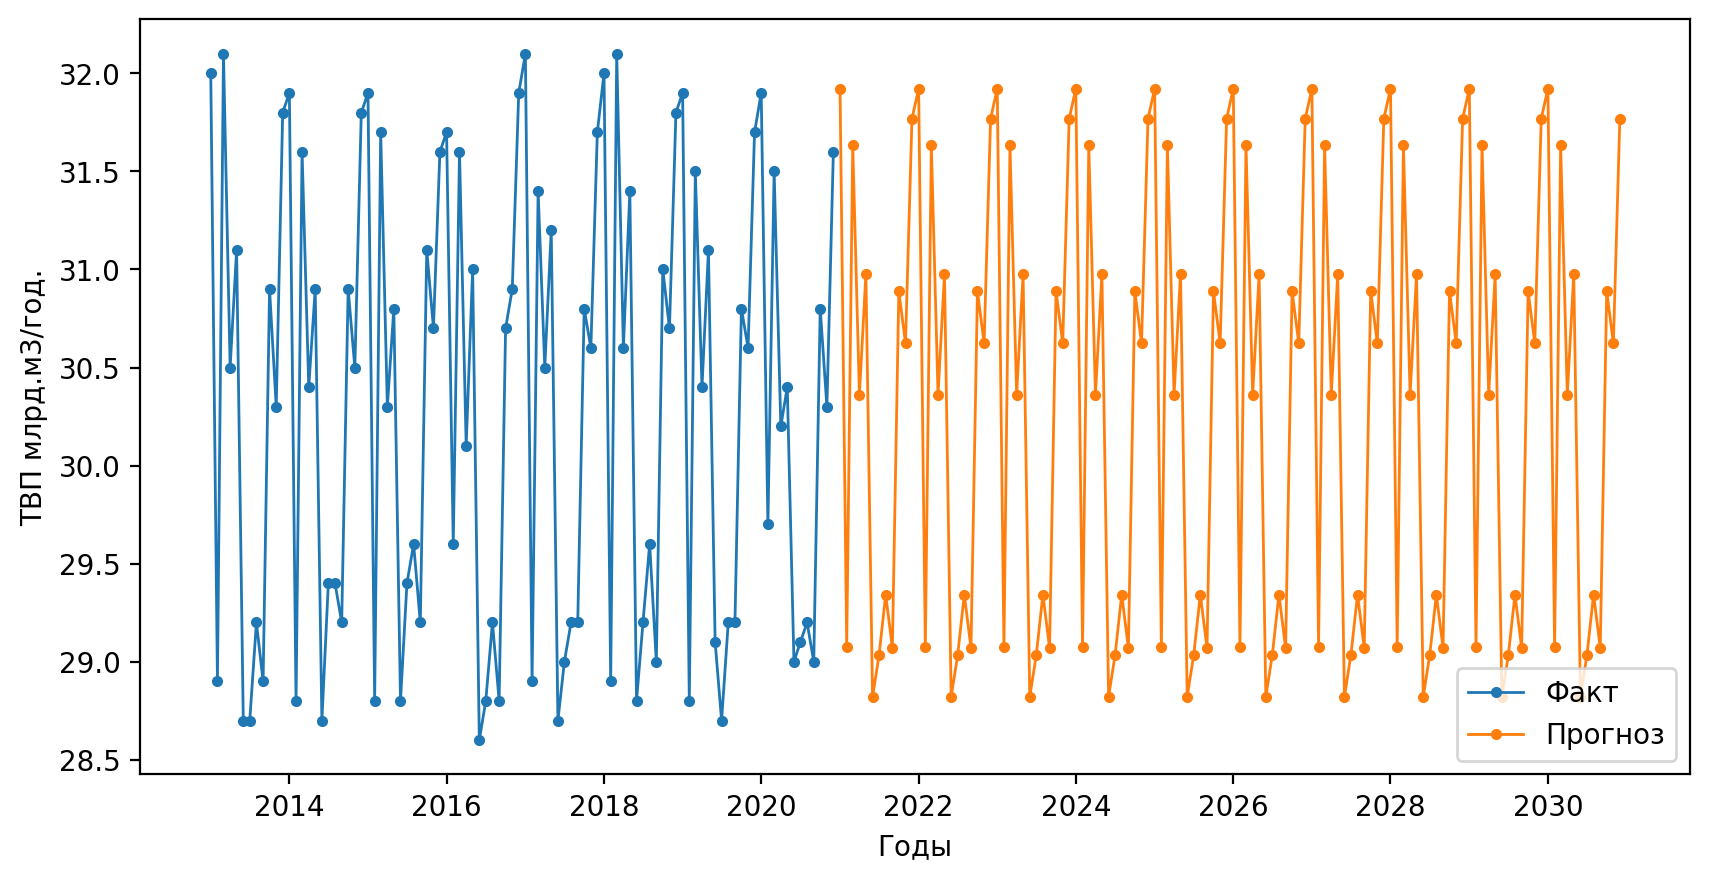

In [28]:
forecast_period_year = 10

forecast_period = 12*forecast_period_year + 1

for_idx = pd.PeriodIndex(pd.date_range(str(result.trend.index[-1].year) + '-' + str(result.trend.index[-1].month),
                                 periods=forecast_period, freq="M"))
for_idx = for_idx[1:]

for_date_year = []
for k in np.arange(forecast_period_year):
    for n in np.arange(1, 13):
        for_date_year.append(result.seasonal.iloc[(result.seasonal.index.year == 2020) &\
                                                  (result.seasonal.index.month == n)][0] + \
                            result.trend.describe()['mean'])

forecast = pd.Series(data=for_date_year, index=for_idx)

fact = pd.Series(data=result.observed.values, index=result.observed.index.to_period())


plt.plot(fact.index.to_timestamp(), 
         fact, marker='o', ms=3, linewidth = 1, label='Факт')
plt.plot(forecast.index.to_timestamp(), 
         forecast, marker='o', ms=3, linewidth = 1, label='Прогноз')
plt.legend()
plt.xlabel('Годы')
plt.ylabel('ТВП млрд.м3/год.')
plt.show()

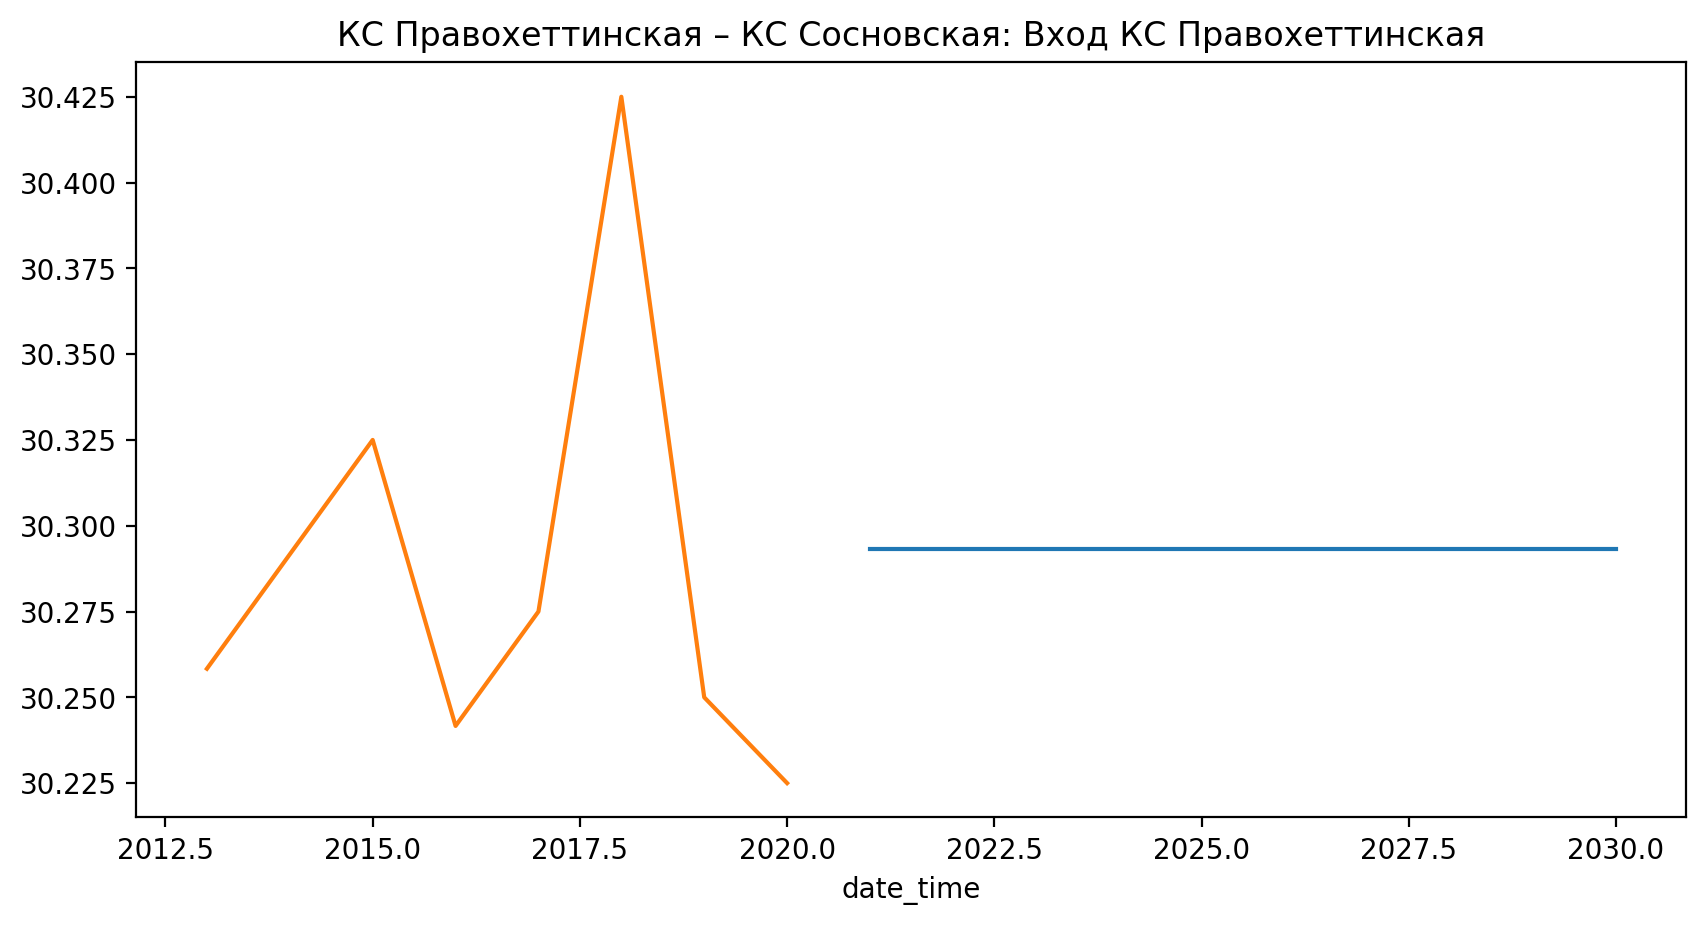

In [80]:
forecast.groupby(by=forecast.index.year).mean().plot()

fact.groupby(by=fact.index.year).mean().plot()

plt.title(cr_line);

In [89]:
type(fact)

pandas.core.series.Series

In [103]:
fact_df = pd.DataFrame(data=fact.groupby(by=fact.index.year).mean(), columns=['tvp'])
fact_df.head()

,tvp
date_time,
2013,30.258333
2014,30.291667
2015,30.325000
2016,30.241667
2017,30.275000


<AxesSubplot:xlabel='date_time'>

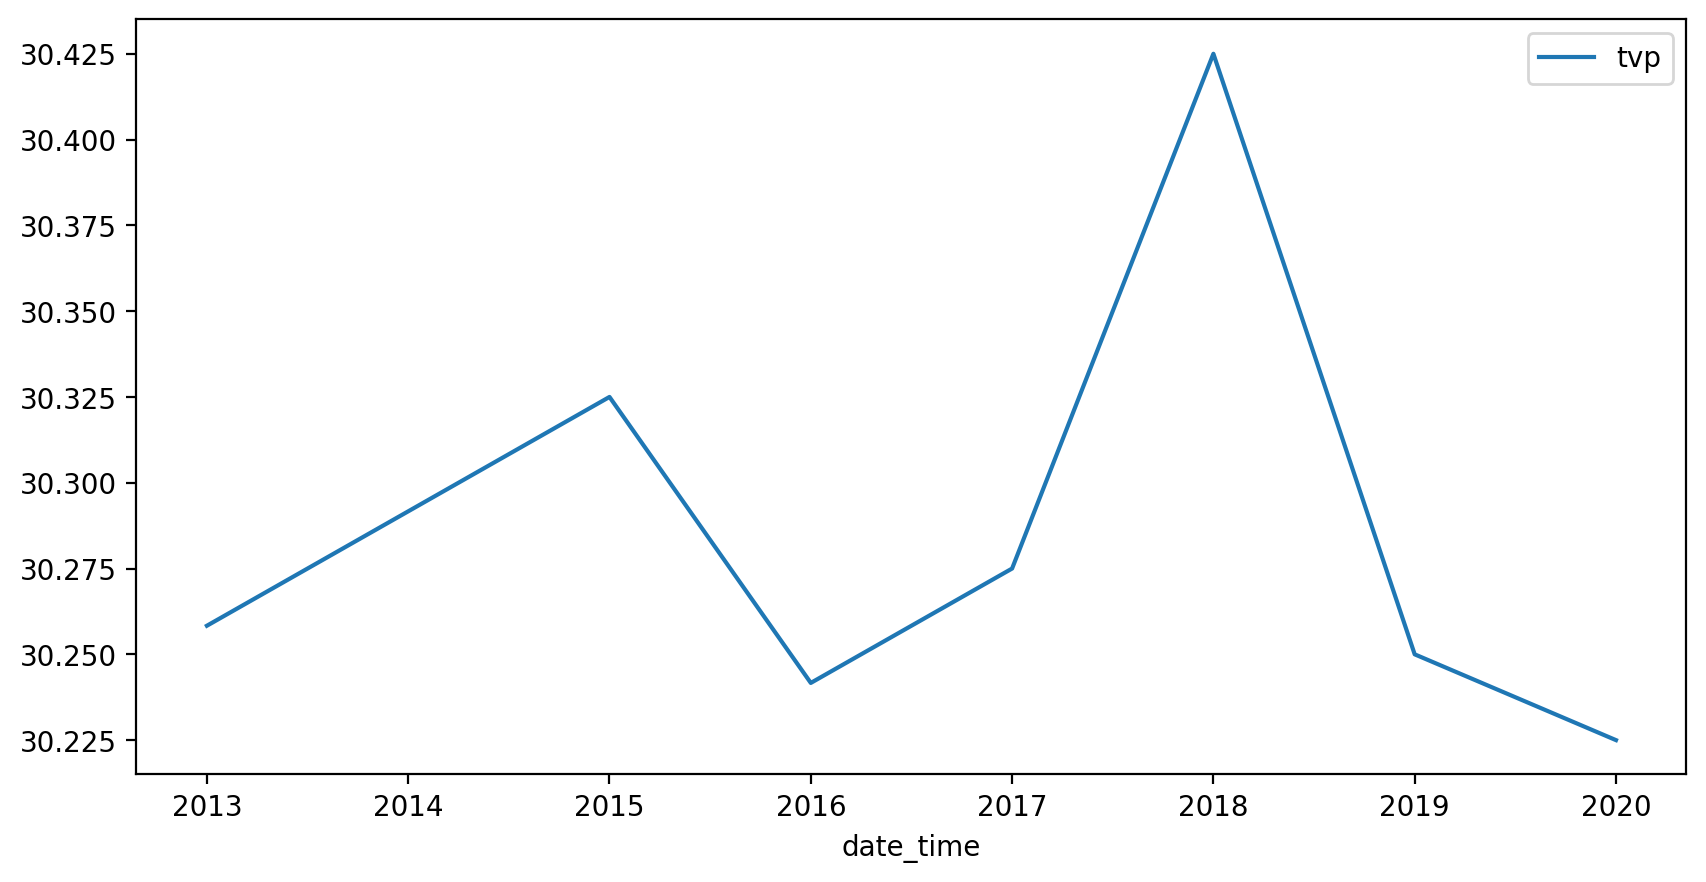

In [104]:
fact_df.plot()

In [112]:
type(fact_df.values)

numpy.ndarray

In [114]:
type(fact_df.index.values)

numpy.ndarray

In [120]:
len(fact_df.values)

8

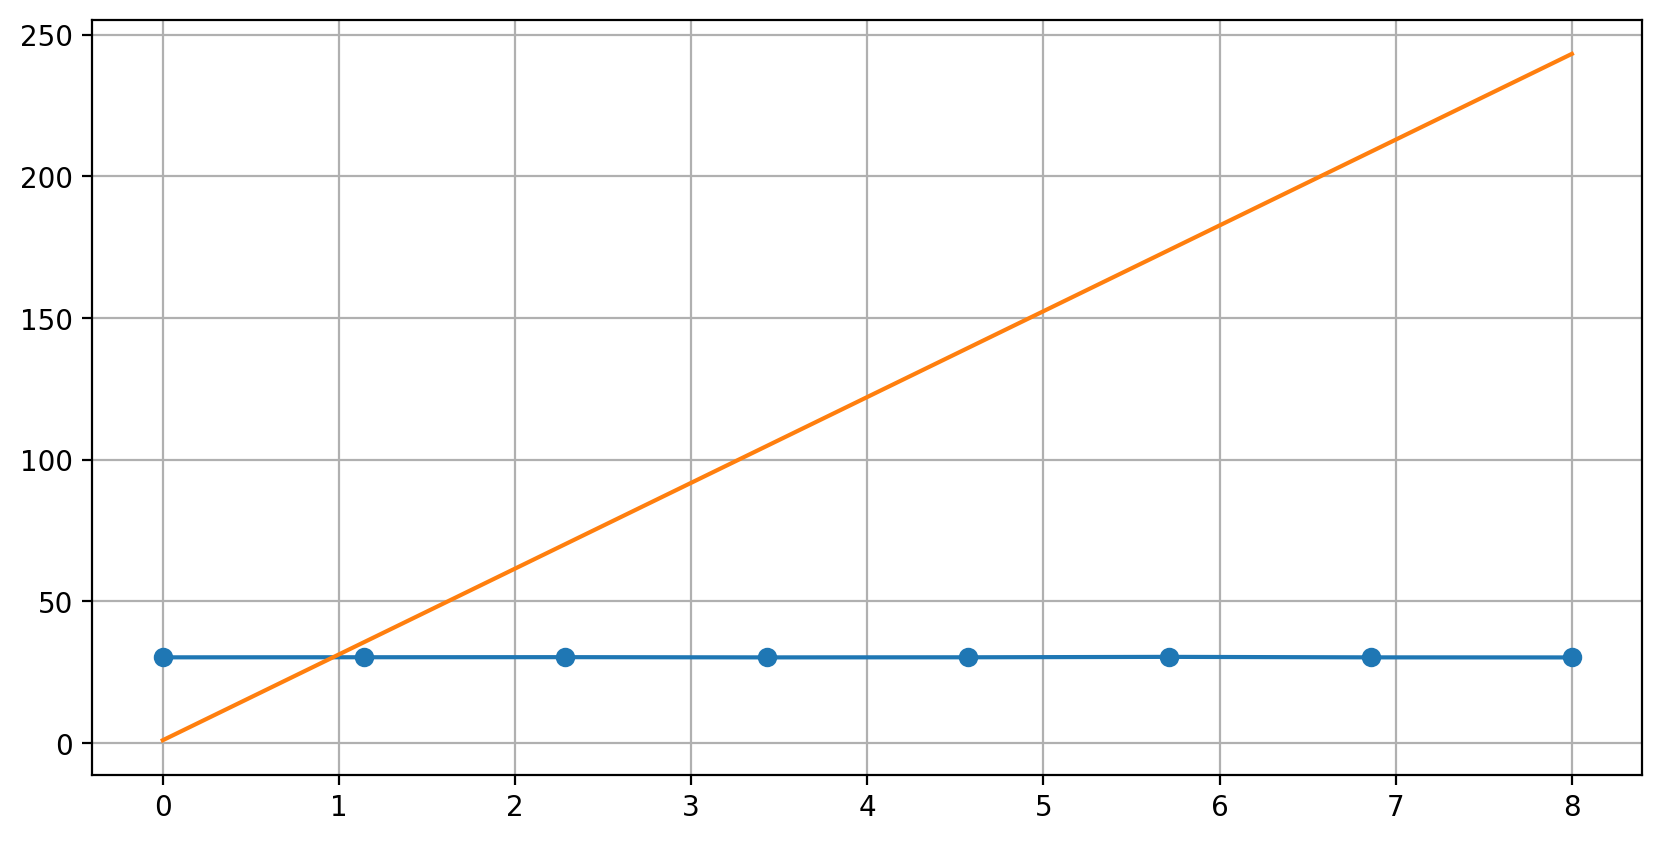

In [158]:
from scipy.optimize import curve_fit

def func(x, a, b, c):
    return a*x + b
#     return a*x**2 + b*x + c
#     return a*np.exp(b*x) + c
#     return a+b*np.log(c*x)

x = np.linspace(0,8,8)
# x = fact_df.index.values
# y = func(x, 5, 3, 4)
y = fact_df.values.T[0]

# generate noisy ydata
# yn = y + 0.2 * y * np.random.normal(size=len(x))

popt, pcov = curve_fit(func, x, y)


fig = plt.figure()
ax = fig.add_subplot(111)
# ax.errorbar(x, yn, yerr = y_sigma, fmt = 'o')
ax.plot(x, y, marker = 'o')
ax.plot(x, np.polyval(popt, x), '-')
# ax.text(0.5, 200, r"a = {0:.3f} +/- {1:.3f}".format(popt[0], pcov[0,0]**0.5))
# ax.text(0.5, 160, r"b = {0:.3f} +/- {1:.3f}".format(popt[1], pcov[1,1]**0.5))
# ax.text(0.5, 80, r"c = {0:.3f} +/- {1:.3f}".format(popt[2], pcov[2,2]**0.5))
ax.grid()
plt.show()

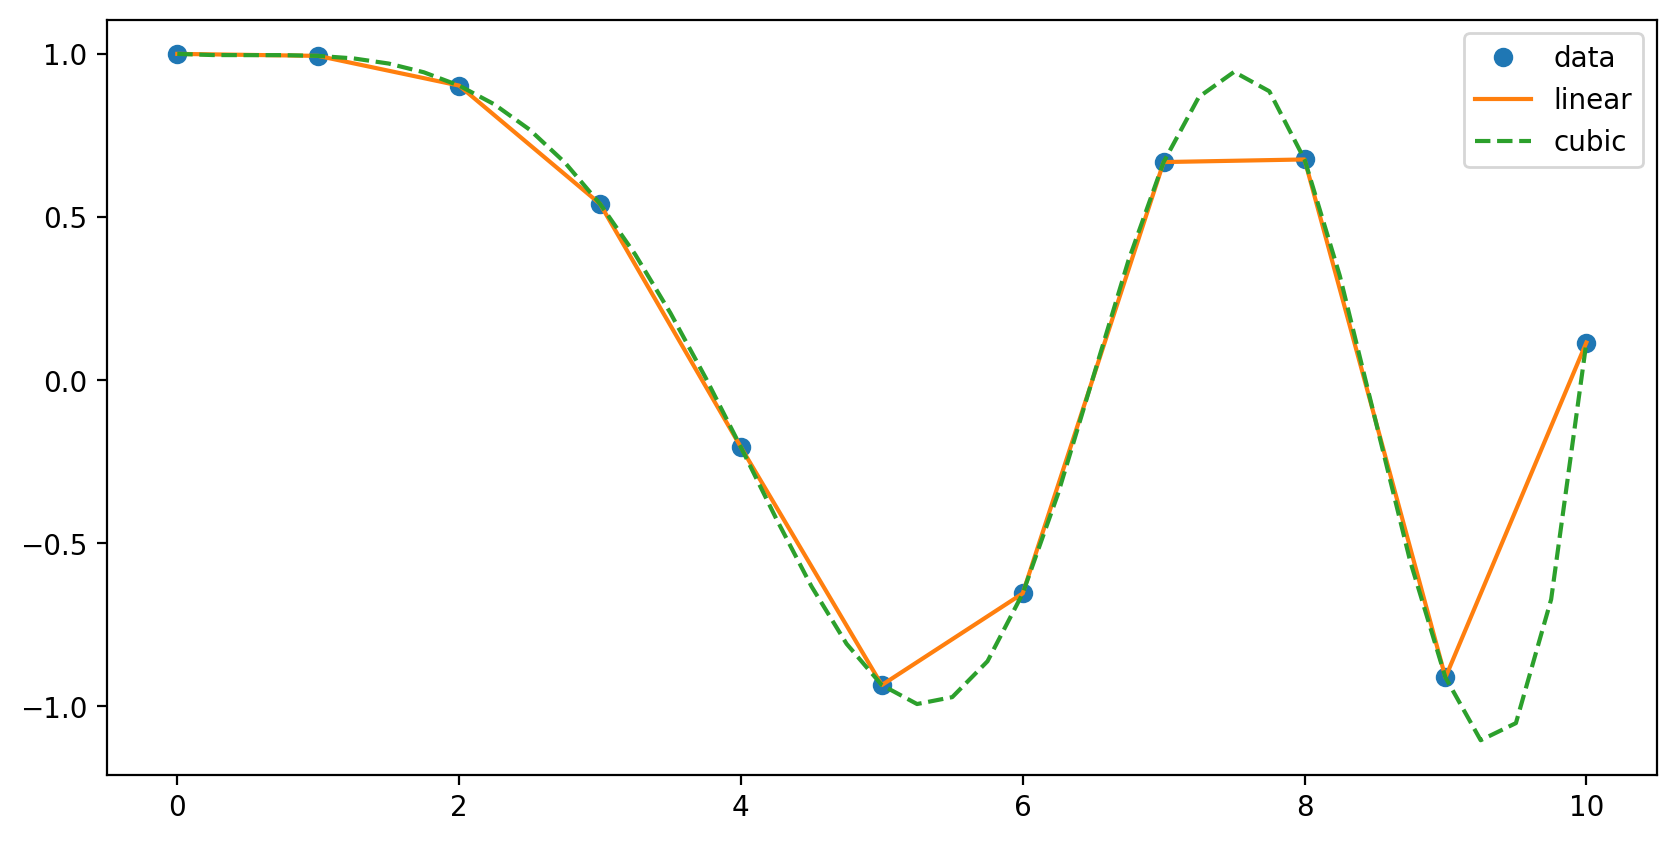

In [168]:
x = np.linspace(0, 10, num=11, endpoint=True)
y = np.cos(-x**2/9.0)
f = interp1d(x, y)
f2 = interp1d(x, y, kind='cubic')

xnew = np.linspace(0, 10, num=41, endpoint=True)

plt.plot(x, y, 'o', xnew, f(xnew), '-', xnew, f2(xnew), '--')
plt.legend(['data', 'linear', 'cubic'], loc='best')
plt.show()